In [1]:
import skimage
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import Progbar

In [3]:
print(tf.__version__)

2.10.1


# Data Preps

In [4]:
import logging
import time
from tqdm.notebook import tqdm

In [5]:

User_Folder = os.path.expanduser('~')
data_path = os.path.join(User_Folder,"Desktop","archive")
print(data_path)


C:\Users\Amay\Desktop\archive


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [7]:
import shutil

In [9]:
os.rename(os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test"),os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainO"))
os.rename(os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train"),os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/extras"))

In [10]:
os.mkdir(os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/valO"))
os.mkdir(os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/valN"))
os.mkdir(os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testO"))
os.mkdir(os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testN"))
os.mkdir(os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainN"))

624 + 250 for training 250 for validation 100 for testing

In [11]:
source = os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/extras/")
destVal = os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/valO")
destTest = os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testO")
destTrain = os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainO")

In [12]:
def moveData(src,dest,nos):
  for no,i in enumerate(os.listdir(src)):
    if no==nos:
      break
    shutil.move(src+i,dest+"/"+i)

In [13]:
moveData(source,destTrain,400)
moveData(source,destVal,300)
moveData(source,destTest,200)

In [14]:
print(len(os.listdir(destTrain)))
print(len(os.listdir(destVal)))
print(len(os.listdir(destTest)))

1024
300
200


# Data Processing

In [15]:
def processData(path,noisyDataPath):
  imgsPaths = os.listdir(path)
  imgsPaths = [path+"/"+i for i in imgsPaths]
  spath = noisyDataPath
  print("Processing...")
  pb_i = Progbar(len(imgsPaths))
  for no,p in enumerate(imgsPaths):
    img = image.load_img(p)
    img = image.img_to_array(img)
    img /= 255.0
    noiseImg = skimage.util.random_noise(img,mode='gaussian', clip=True,var=0.155**2)
    image.save_img(spath+"img"+str(no)+".jpeg",noiseImg)
    pb_i.add(1)
  print("Saving...")
  pb_i = Progbar(len(imgsPaths))
  for no,src in enumerate(imgsPaths):
    newName = path+"/"+"img"+str(no)+".jpeg"
    os.rename(src,newName)
    pb_i.add(1)

In [16]:
destTrainN = os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainN/")
destValN = os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/valN/")
destTestN = os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testN/")

In [17]:
processData(destTrain,destTrainN)

Processing...
1024/1024 [==============================] - 312s 304ms/step
Saving...
1024/1024 [==============================] - 1s 564us/step


In [18]:
processData(destVal,destValN)

Processing...
300/300 [==============================] - 107s 355ms/step
Saving...
300/300 [==============================] - 0s 321us/step


In [19]:
processData(destTest,destTestN)

Processing...
200/200 [==============================] - 78s 389ms/step
Saving...
200/200 [==============================] - 0s 339us/step


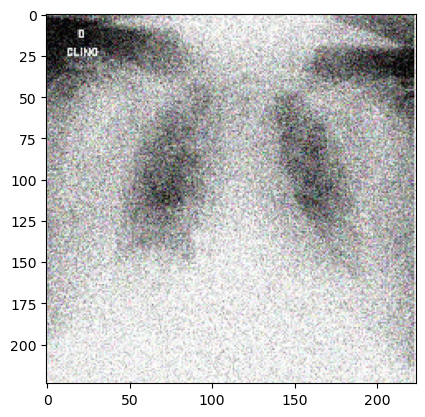

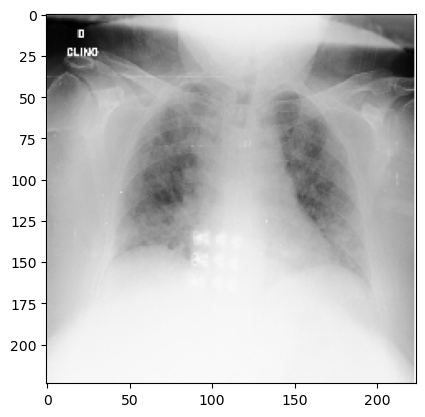

In [20]:
imgN = image.load_img(os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainN/img0.jpeg"),target_size=(224,224))
imgN = image.img_to_array(imgN)
imgN /= 255.0

img1 = image.load_img(destTrain+"/"+"img0.jpeg",target_size=(224,224))
img1 = image.img_to_array(img1)
img1 /= 255.0

plt.imshow(imgN)
plt.show()
plt.imshow(img1)
plt.show()

In [21]:
img1.shape

(224, 224, 3)

In [25]:
imgN.shape

(224, 224, 3)

In [26]:
def datagen(nPath, oPath, batchSize):
  noisy = []
  original = []
  i=0
  while(i!=len(nPath)):
    for iN in range(batchSize):
      if (i+iN)>=len(nPath):
        i = 2*len(nPath)
        break
      imgN = image.load_img(nPath[i+iN],target_size=(224,224))
      imgN = image.img_to_array(imgN)
      imgN /= 255.0
      noisy.append(imgN)
      imgO = image.load_img(oPath[i+iN],target_size=(224,224))
      imgO = image.img_to_array(imgO)
      imgO /= 255.0
      original.append(imgO)

    if i>=len(nPath):
      break

    yield (np.array(noisy),np.array(original))
    noisy = []
    original = []
    i += batchSize

In [27]:
trainNoisy = os.listdir(os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainN"))
trainNoisy = [os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainN/")+i for i in trainNoisy]

trainOriginal = os.listdir(os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainO"))
trainOriginal = [os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainO/")+i for i in trainOriginal]

In [31]:
print(trainNoisy)
print(trainOriginal)

['C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainN/img0.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainN/img1.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainN/img10.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainN/img100.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainN/img1000.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainN/img1001.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainN/img1002.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/trainN/img1003.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Datase

In [28]:
print(len(trainNoisy))
print(len(trainOriginal))

1024
1024


In [29]:
valNoisy = os.listdir(os.path.join(data_path,("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/valN")))
valNoisy = [os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/valN/")+i for i in valNoisy]

valOriginal = os.listdir(os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/valO"))
valOriginal = [os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/valO/")+i for i in valOriginal]

In [32]:
print(valNoisy)
print(valOriginal)

['C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/valN/img0.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/valN/img1.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/valN/img10.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/valN/img100.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/valN/img101.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/valN/img102.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/valN/img103.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/valN/img104.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-X

In [30]:
print(len(valNoisy))
print(len(valOriginal))

300
300


In [33]:
testNoisy = os.listdir(os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testN"))
testNoisy = [os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testN/")+i for i in testNoisy]

testOriginal = os.listdir(os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testO"))
testOriginal = [os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testO/")+i for i in testOriginal]

In [34]:
print(testNoisy)
print(testOriginal)

['C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testN/img0.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testN/img1.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testN/img10.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testN/img100.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testN/img101.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testN/img102.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testN/img103.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testN/img104.jpeg', 'C:\\Users\\Amay\\Desktop\\archive\\Coronahack-Chest-XRay-Dataset/Coronahack

In [35]:
print(len(testNoisy))
print(len(testOriginal))

200
200


In [36]:
trainDatagen = datagen(trainNoisy, trainOriginal, 100)

Batch 1:


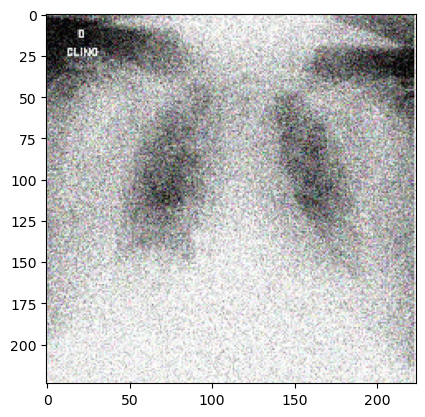

(100, 224, 224, 3)


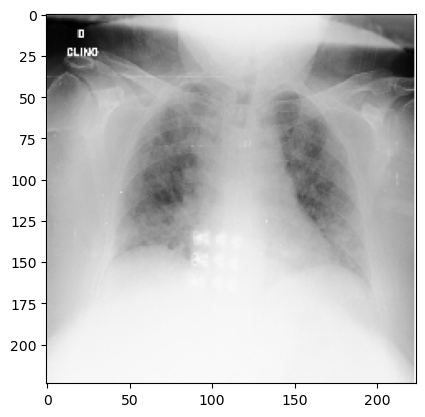

(100, 224, 224, 3)
Batch 2:


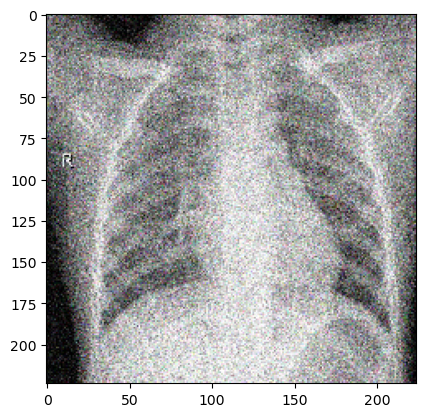

(100, 224, 224, 3)


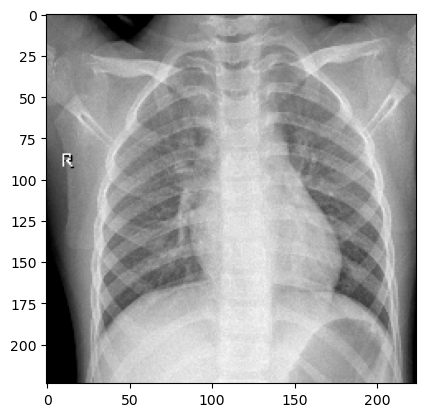

(100, 224, 224, 3)
Batch 3:


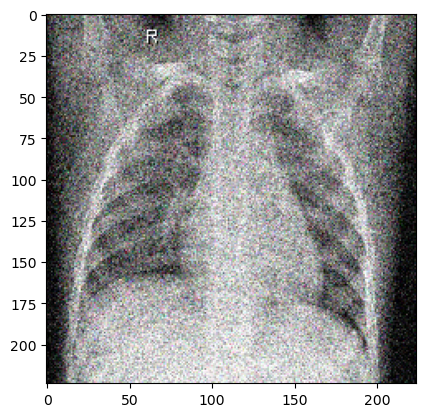

(100, 224, 224, 3)


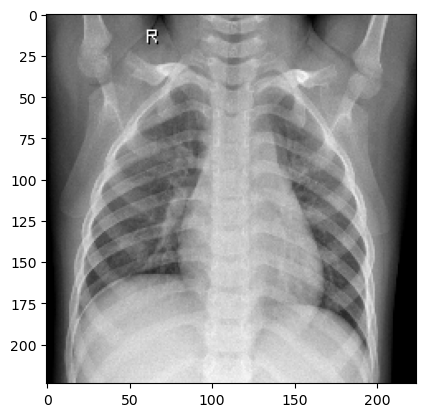

(100, 224, 224, 3)
Batch 4:


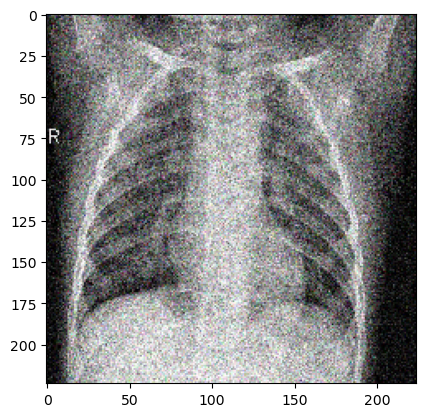

(100, 224, 224, 3)


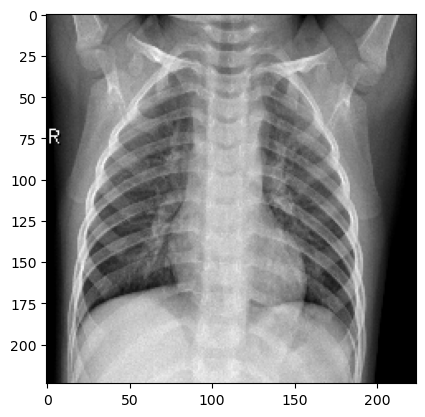

(100, 224, 224, 3)
Batch 5:


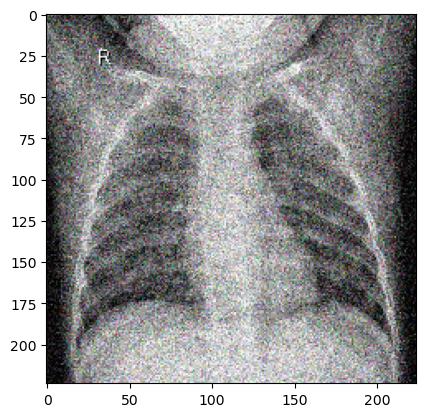

(100, 224, 224, 3)


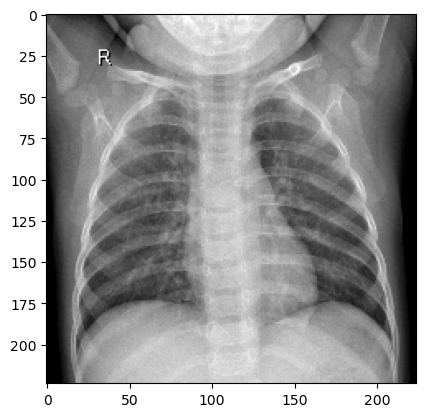

(100, 224, 224, 3)
Batch 6:


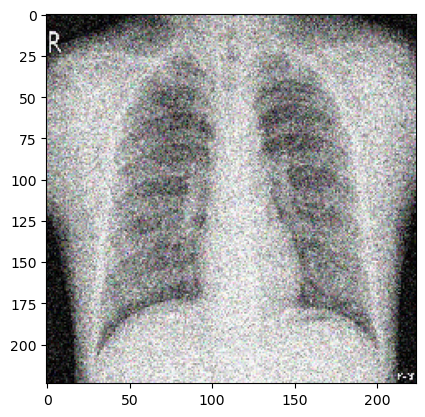

(100, 224, 224, 3)


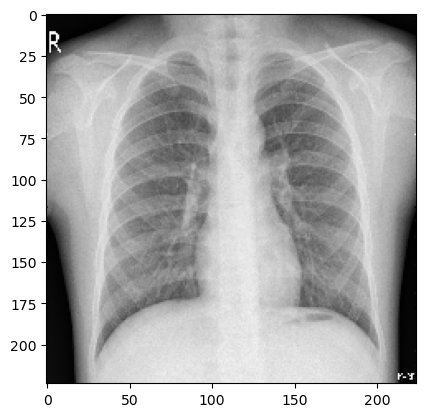

(100, 224, 224, 3)
Batch 7:


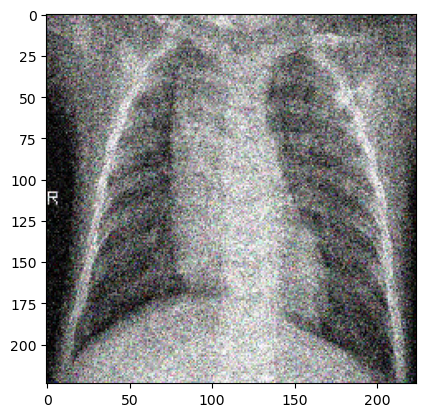

(100, 224, 224, 3)


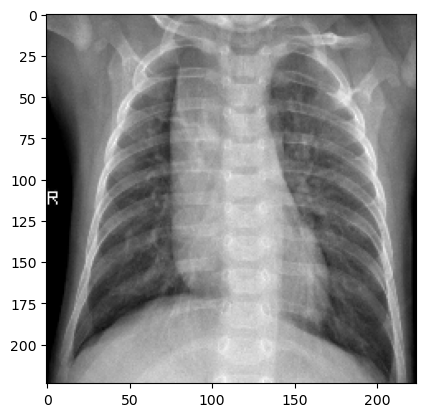

(100, 224, 224, 3)
Batch 8:


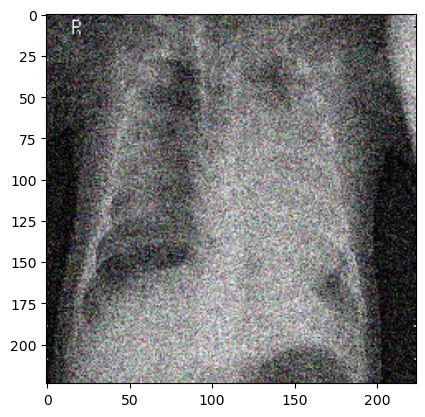

(100, 224, 224, 3)


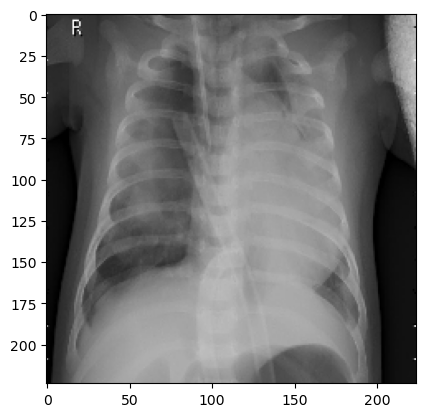

(100, 224, 224, 3)
Batch 9:


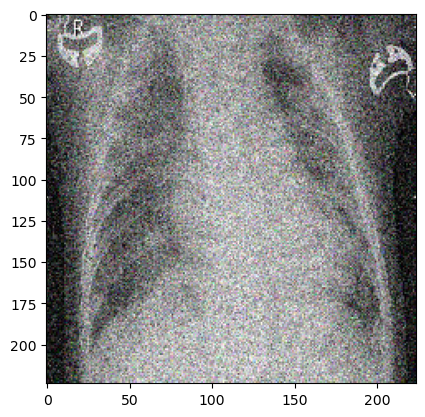

(100, 224, 224, 3)


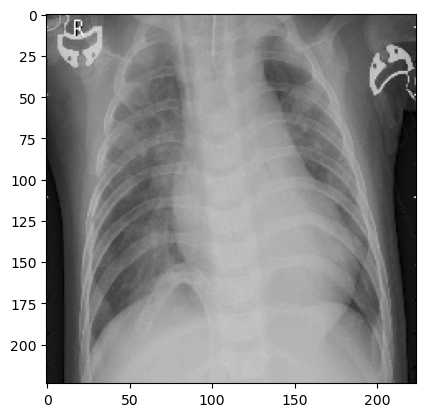

(100, 224, 224, 3)
Batch 10:


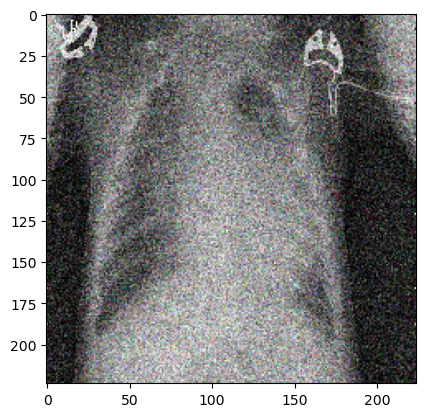

(100, 224, 224, 3)


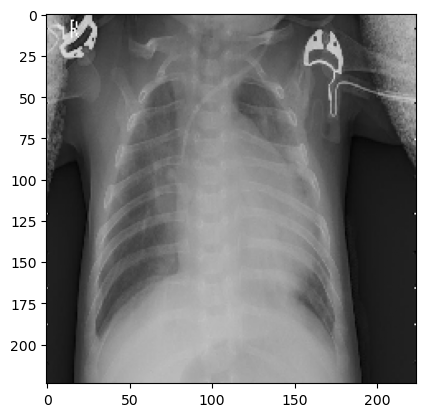

(100, 224, 224, 3)


In [37]:
x = 1
for imgsN,imgsO in trainDatagen:
  print(f"Batch {x}:")
  plt.imshow(imgsN[0])
  plt.show()
  print(imgsN.shape)
  plt.imshow(imgsO[0])
  plt.show()
  print(imgsO.shape)
  x+=1

In [38]:
imgN = image.load_img(os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testN/img0.jpeg"),target_size=(224,224))
imgN = image.img_to_array(imgN)
imgN /= 255.0
imgN = np.expand_dims(imgN,axis=0)

In [41]:
# DONE :)

# Models, Training and Testing

In [42]:
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import callbacks

In [43]:
@tf.function()
def ssim_loss(y_true, y_pred):
  # Loss to be calculated thats why 1-ssim_val
  return 1-tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [44]:
class SSIMMetric(tf.keras.metrics.Metric):
  def __init__(self, name='ssim_metric', **kwargs):
    super(SSIMMetric, self).__init__(name=name, **kwargs)
    self.score = self.add_weight(name='tp', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    self.score.assign(tf.reduce_mean(tf.image.ssim(y_true,y_pred,1.0)))

  def result(self):
    return self.score

In [45]:
class PSNRMetric(tf.keras.metrics.Metric):
  def __init__(self, name='psnr_metric', **kwargs):
    super(PSNRMetric, self).__init__(name=name, **kwargs)
    self.score = self.add_weight(name='tp', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    self.score.assign(tf.image.psnr(y_true,y_pred,max_val=1.0))

  def result(self):
    return self.score

In [46]:
@tf.function()
def ssim_metric(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true,y_pred,1.0))

In [47]:
@tf.function()
def psnr(y,y_p):
  return tf.image.psnr(y,y_p,max_val=1.0)

In [48]:
@tf.function()
def psnr_loss(y,y_p):
  return 100-tf.image.psnr(y,y_p,max_val=1.0)

In [49]:
lrRonPlatue = callbacks.ReduceLROnPlateau(monitor='val_loss',patience=3, factor=0.08)

In [50]:
def fit(train_data,steps_per_epoch, validation_data, validation_steps):
  metrics_names = ['psnr value', 'ssim value']
  for epoch in range(epochs):
    trainData = datagen(trainNoisy,trainOriginal,train_batch)
    valData = datagen(valNoisy,valOriginal,batchSize=val_batch)
    print(f"Epoch: {epoch}:\n")
    pb_i = Progbar(len(trainNoisy), stateful_metrics=metrics_names)
    for step, (xbatch,ybatch) in enumerate(trainData):
      with tf.GradientTape() as tape:
        y_p = modelN(xbatch, training=True)
        lossVal = ssim_loss(ybatch, y_p)
      gradients = tape.gradient(lossVal, modelN.trainable_weights)
      adam.apply_gradients(zip(gradients, modelN.trainable_weights))
      psnrMet.update_state(ybatch[step], y_p[step])
      ssimMet.update_state(ybatch[step],y_p[step])
      values=[('psnr value',psnrMet.result()), ('ssim value',ssimMet.result())]
      pb_i.add(train_batch, values=values)
    psnrVal = psnrMet.result()
    ssimVal = ssimMet.result()
    print(f"SSIM Loss: {lossVal}; SSIM Score: {ssimVal}; PSNR Score: {psnrVal}\t")
    psnrMet.reset_states()
    ssimMet.reset_states()
    for step, (xbatch, ybatch) in enumerate(valData):
      ypV = modelN(xbatch, training=True)
      lossVal = ssim_loss(ybatch, ypV)
      psnrMet.update_state(ybatch[step], ypV[step])
      ssimMet.update_state(ybatch[step],y_p[step])
    psnrVal = psnrMet.result()
    ssimVal = ssimMet.result()
    print(f" Validation:: SSIM Loss: {lossVal}; SSIM Score: {ssimVal}; PSNR Score: {psnrVal}\n")
    psnrMet.reset_states()
    ssimMet.reset_states()

def evaluate(testDataGen, stepsPerEpoch):
  for step, (xbatch, ybatch) in enumerate(testDataGen):
    ypV = modelN(xbatch, training=True)
    lossVal = ssim_loss(ybatch, ypV)
    psnrMet.update_state(ybatch[step], ypV[step])
    ssimMet.update_state(ybatch[step],y_p[step])
  psnrVal = psnrMet.result()
  ssimVal = ssimMet.result()
  print(f"Loss: {lossVal}; SSIM Score: {ssimVal}; PSNR Score: {psnrVal}\n")
  psnrMet.reset_states()
  ssimMet.reset_states()

In [51]:
# ConvLayer
class ConvLayer(layers.Layer):
  def __init__(self, out_channels, kernel_size=3):
    super(ConvLayer, self).__init__()
    self.conv = layers.Conv2D(out_channels, kernel_size, padding='same')
    self.bn = layers.BatchNormalization()

  def call(self, input_tensor, training=False):
    c = self.conv(input_tensor)
    c = self.bn(c,training=training)
    c = tf.nn.relu(c)
    return c

# Residual Dense Network for Image Restoration

In [52]:
class BaseConv(layers.Layer):
  def __init__(self, filters=96, kernel_size=3, strides=1, padding='same', alpha=0.2):
    super(BaseConv, self).__init__()
    self.conv = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)
    self.batchNorm = layers.BatchNormalization()
    self.leakyRelu = layers.LeakyReLU(alpha=alpha)

  def call(self, input_tensor, training=False):
    x = self.conv(input_tensor,training=training)
    x = self.batchNorm(x)
    x = self.leakyRelu(x)
    return x

In [53]:
class DenseBlock(layers.Layer):
  def __init__(self, filters=96, k=3):
    super(DenseBlock, self).__init__()
    self.k = k
    self.convBlocks = [BaseConv(filters=filters, kernel_size=3) for i in range(k)]
    self.convBase2 = BaseConv(filters=filters*4, kernel_size=1)
    self.batchNorm = layers.BatchNormalization()
    self.leakyRelu = layers.LeakyReLU(alpha=0.2)
    self.convBase3 = BaseConv(filters=filters, kernel_size=3)

  def call(self, input_tensor, training=False):
    x_temp1 = self.convBlocks[0](input_tensor, training=training)
    x = layers.Concatenate(axis=-1)([input_tensor, x_temp1])
    for i in range(1,self.k):
      x_temp2 = self.convBlocks[i](x, training=training)
      x = layers.Concatenate(axis=-1)([x, x_temp2])

    # if self.k>3:
    #   x = self.batchNorm(x)
    #   x = self.leakyRelu(x)
    #   x = self.convBase2(x, training=training)

    x = self.convBase3(x, training=training)
    return x

In [54]:
class ResDenseBlock(layers.Layer):
  def __init__(self, filters=96, kr=3):
    super(ResDenseBlock, self).__init__()
    self.denseBlock = DenseBlock(filters=filters, k=kr)
    self.convBase = BaseConv(filters=filters, kernel_size=3)

  def call(self, input_tensor, training=False):
    x = self.denseBlock(input_tensor)
    x = layers.Concatenate(axis=-1)([input_tensor,x])
    x = self.convBase(x)
    x = layers.Add()([input_tensor, x])
    return x

In [55]:
def mainModel(inputs,ks=3, kr=3, filters=96):
  resb = []
  x = BaseConv(filters=filters, kernel_size=3)(inputs)
  z = BaseConv(filters=filters, kernel_size=3)(x)
  resb.append(z)
  for i in range(ks):
      resb.append(ResDenseBlock(kr=kr, filters=filters)(resb[i]))

  resb = resb[1:]
  concat = layers.Concatenate(axis=-1)(resb)

  y = BaseConv(filters=filters, kernel_size=1)(concat)
  y = BaseConv(filters=filters, kernel_size=3)(y)
  # y = layers.MaxPool2D()(y)
  # y = layers.Conv2DTranspose(filters=filters, kernel_size=3, strides=2, padding='same')(y)

  y = layers.Add()([y, x])
  # y = layers.Conv2DTranspose(filters=filters, kernel_size=3, strides=2, padding='same')(y)

  outputs = BaseConv(filters=3, kernel_size=3, alpha=0.0)(y)
  outputs = layers.Add()([inputs, outputs])
  return outputs

In [56]:
inputs = layers.Input(shape=(224,224,3))
resDesModel = tf.keras.Model(inputs=inputs, outputs=mainModel(inputs,ks=3,kr=3,filters=64))
resDesModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 base_conv (BaseConv)           (None, 224, 224, 64  2048        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 base_conv_1 (BaseConv)         (None, 224, 224, 64  37184       ['base_conv[0][0]']              
                                )                                                             

In [60]:
resDesModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),loss=ssim_loss,metrics=[ssim_metric, psnr,'mse'])

## Training

In [61]:
train_batch_size = 8
val_batch_size = 4
epochs = 30

In [62]:
steps = (len(trainNoisy))//train_batch_size

In [63]:
valStep = (len(valNoisy))//val_batch_size

In [65]:
train_psnr = []
val_psnr =[]
train_ssim = []
val_ssim = []
for i in range(epochs):
  trainData = datagen(trainNoisy,trainOriginal,train_batch_size)
  valData = datagen(valNoisy,valOriginal,batchSize=val_batch_size)
  print(f"Epoch {i}")
  hist = resDesModel.fit(trainData,steps_per_epoch=steps, validation_data=valData, validation_steps=valStep)
  train_psnr.append(hist.history['psnr'])
  val_psnr.append(hist.history['val_psnr'])
  train_ssim.append(hist.history['ssim_metric'])
  val_ssim.append(hist.history['val_ssim_metric'])

Epoch 0
128/128 [==============================] - 2322s 18s/step - loss: 0.4503 - ssim_metric: 0.5497 - psnr: 12.1819 - mse: 0.1033 - val_loss: 0.7402 - val_ssim_metric: 0.2598 - val_psnr: 18.7196 - val_mse: 0.0134
Epoch 1
 12/128 [=>............................] - ETA: 33:11 - loss: 0.3571 - ssim_metric: 0.6429 - psnr: 12.5775 - mse: 0.0562

KeyboardInterrupt: 

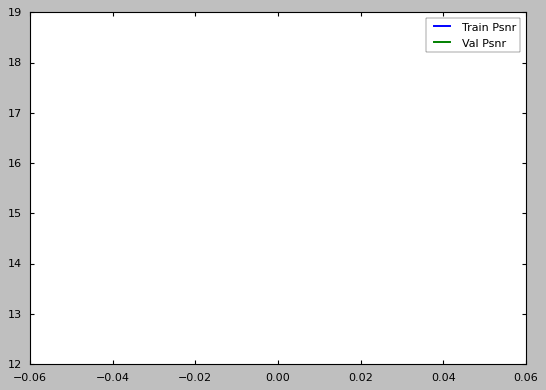

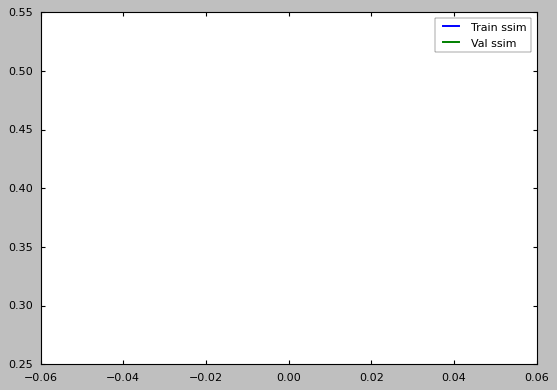

In [78]:
plt.plot(train_psnr,label="Train Psnr")
plt.plot(val_psnr, label="Val Psnr")
plt.legend()
plt.show()
plt.plot(train_ssim,label="Train ssim")
plt.plot(val_ssim, label="Val ssim")
plt.legend()
plt.show()

## Testing

In [67]:
resDesModel.evaluate(datagen(testNoisy,testOriginal,batchSize=4),steps=25)

25/25 [==============================] - 39s 2s/step - loss: 0.7375 - ssim_metric: 0.2625 - psnr: 18.6183 - mse: 0.0138


[0.7374675869941711,
 0.26253238320350647,
 18.6182804107666,
 0.013753339648246765]

In [72]:
imgN = image.load_img(os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testN/img0.jpeg"),target_size=(224,224))
imgN = image.img_to_array(imgN)
imgN /= 255.0
imgN = np.expand_dims(imgN,axis=0)

In [70]:
imgP1 = resDesModel.predict(imgN)

1/1 [==============================] - 1s 1s/step


In [73]:
img0 = image.load_img(os.path.join(data_path,"Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/testO/img0.jpeg"),target_size=(224,224))
img0 = image.img_to_array(img0)
img0 /= 255.0

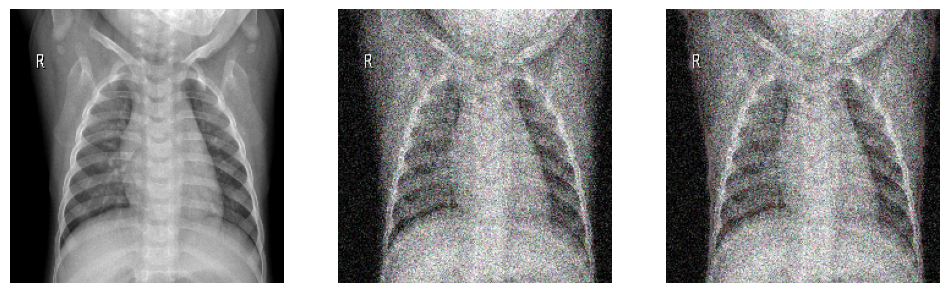

In [74]:
fig, axs = plt.subplots(1, 3, figsize=(12, 12))
[ax.set_axis_off() for ax in axs.ravel()]
axs[0].imshow(img0)
axs[2].imshow(imgP1[0])
axs[1].imshow(imgN[0])